# 3. Imputation

In [25]:
%load_ext autoreload
%autoreload 2

import os
from tqdm.auto import tqdm
import matplotlib.pyplot as pl
import pathlib

import numpy as np
import pandas as pd
import lifelines
from lifelines import CoxPHFitter
from sklearn.model_selection import StratifiedKFold


from joblib import Parallel, delayed
from tqdm.notebook import tqdm
import neptune
import warnings
warnings.filterwarnings("ignore")
import shutil

dataset_name = "cvd_massive_excl_emb"
path = "/data/analysis/ag-reils/steinfej/code/umbrella/pre/ukbb"
data_path = "/data/analysis/ag-reils/ag-reils-shared/cardioRS/data"
dataset_path = f"{data_path}/2_datasets_pre/{dataset_name}"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Read data

In [26]:
data = pd.read_feather(f"{dataset_path}/baseline.feather")
data_description = pd.read_feather(f"{dataset_path}/baseline_clinical_description.feather")

In [27]:
covariates = data_description[data_description.isTarget==False].covariate.to_list()[1:]
targets = data_description[data_description.isTarget==True].covariate.to_list()
data_description

,id,covariate,dtype,isTarget,based_on,aggr_fn
0,1,eid,integer,False,eid,NaN
1,2,age_at_recruitment,numeric,False,basics,NaN
2,3,sex,category,False,basics,NaN
3,4,ethnic_background,category,False,basics,NaN
4,5,townsend_deprivation_index_at_recruitment,numeric,False,basics,NaN
...,...,...,...,...,...,...
3741,3742,ASCVD_event_time,numeric,True,score_ASCVD,NaN
3742,3743,QRISK3_event,integer,True,score_QRISK3,NaN
3743,3744,QRISK3_event_time,numeric,True,score_QRISK3,NaN
3744,3745,MACE_event,integer,True,score_MACE,NaN


In [28]:
data

,eid,PGS000011,PGS000013,PGS000016,PGS000018,PGS000039,PGS000057,PGS000058,PGS000059,PGS000116,...,death_cvd_event,death_cvd_event_time,SCORE_event,SCORE_event_time,ASCVD_event,ASCVD_event_time,QRISK3_event,QRISK3_event_time,MACE_event,MACE_event_time
0,1000018,3.170770,14.182161,25.478597,-7.910004,0.196099,3.690275,8.513230,4.060235,2.543097,...,0,10.625599,0,10.625599,0,10.335387,0,10.335387,0,10.335387
1,1000020,3.935565,14.203609,25.508855,-7.338207,0.382054,4.170000,8.665529,3.640000,2.575014,...,0,12.355921,0,12.355921,0,12.065708,0,12.065708,0,12.065708
2,1000037,4.223654,14.248176,25.549722,-7.533061,0.189988,4.288627,8.540908,5.541451,2.441255,...,0,11.627652,0,11.627652,1,7.969884,1,7.969884,0,11.337440
3,1000043,3.529575,14.176502,25.394145,-7.768648,0.289388,4.130000,8.515447,4.261098,2.740589,...,0,11.069131,0,11.069131,1,5.122519,1,5.122519,1,5.122519
4,1000051,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,14.050650,0,14.050650,0,13.760438,0,13.760438,0,13.760438
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
502499,6025150,4.181800,14.053589,25.402026,-7.499164,0.272956,4.470000,8.425411,4.660235,2.419166,...,0,12.996578,0,12.996578,0,12.706366,0,12.706366,0,12.706366
502500,6025165,4.315743,14.131477,25.417482,-7.736421,0.275103,3.900941,8.046961,4.000196,2.721753,...,0,11.819302,0,11.819302,0,11.529090,0,11.529090,0,11.529090
502501,6025173,3.096671,14.186225,25.488755,-8.079815,0.352918,3.507804,7.994697,3.690706,2.687853,...,0,11.778234,0,11.778234,0,11.488022,0,11.488022,0,11.488022
502502,6025182,3.699646,14.134693,25.439013,-7.962928,0.343860,4.020000,8.151277,3.960000,2.692526,...,0,9.993155,0,9.993155,0,9.702943,0,9.702943,0,9.702943


## Visualize missing values

In [29]:
import numpy as np
import matplotlib as mpl
from matplotlib import gridspec
import matplotlib.pyplot as plt
from scipy.cluster import hierarchy
import seaborn as sns
import pandas as pd
import warnings

def nullity_sort(df, sort=None, axis='columns'):
    """
    Sorts a DataFrame according to its nullity, in either ascending or descending order.
    :param df: The DataFrame object being sorted.
    :param sort: The sorting method: either "ascending", "descending", or None (default).
    :return: The nullity-sorted DataFrame.
    """
    if sort is None:
        return df
    elif sort not in ['ascending', 'descending']:
        raise ValueError('The "sort" parameter must be set to "ascending" or "descending".')

    if axis not in ['rows', 'columns']:
        raise ValueError('The "axis" parameter must be set to "rows" or "columns".')

    if axis == 'columns':
        if sort == 'ascending':
            return df.iloc[np.argsort(df.count(axis='columns').values), :]
        elif sort == 'descending':
            return df.iloc[np.flipud(np.argsort(df.count(axis='columns').values)), :]
    elif axis == 'rows':
        if sort == 'ascending':
            return df.iloc[:, np.argsort(df.count(axis='rows').values)]
        elif sort == 'descending':
            return df.iloc[:, np.flipud(np.argsort(df.count(axis='rows').values))]


def nullity_filter(df, filter=None, p=0, n=0):
    """
    Filters a DataFrame according to its nullity, using some combination of 'top' and 'bottom' numerical and
    percentage values. Percentages and numerical thresholds can be specified simultaneously: for example,
    to get a DataFrame with columns of at least 75% completeness but with no more than 5 columns, use
    `nullity_filter(df, filter='top', p=.75, n=5)`.
    :param df: The DataFrame whose columns are being filtered.
    :param filter: The orientation of the filter being applied to the DataFrame. One of, "top", "bottom",
    or None (default). The filter will simply return the DataFrame if you leave the filter argument unspecified or
    as None.
    :param p: A completeness ratio cut-off. If non-zero the filter will limit the DataFrame to columns with at least p
    completeness. Input should be in the range [0, 1].
    :param n: A numerical cut-off. If non-zero no more than this number of columns will be returned.
    :return: The nullity-filtered `DataFrame`.
    """
    if filter == 'top':
        if p:
            df = df.iloc[:, [c >= p for c in df.count(axis='rows').values / len(df)]]
        if n:
            df = df.iloc[:, np.sort(np.argsort(df.count(axis='rows').values)[-n:])]
    elif filter == 'bottom':
        if p:
            df = df.iloc[:, [c <= p for c in df.count(axis='rows').values / len(df)]]
        if n:
            df = df.iloc[:, np.sort(np.argsort(df.count(axis='rows').values)[:n])]
    return df

def matrix(df,
           filter=None, n=0, p=0, sort=None,
           figsize=(25, 10), width_ratios=(15, 1), color=(0.25, 0.25, 0.25),
           fontsize=16, labels=None, sparkline=True, inline=False,
           freq=None, ax=None):
    """
    A matrix visualization of the nullity of the given DataFrame.
    :param df: The `DataFrame` being mapped.
    :param filter: The filter to apply to the heatmap. Should be one of "top", "bottom", or None (default).
    :param n: The max number of columns to include in the filtered DataFrame.
    :param p: The max percentage fill of the columns in the filtered DataFrame.
    :param sort: The row sort order to apply. Can be "ascending", "descending", or None.
    :param figsize: The size of the figure to display.
    :param fontsize: The figure's font size. Default to 16.
    :param labels: Whether or not to display the column names. Defaults to the underlying data labels when there are
    50 columns or less, and no labels when there are more than 50 columns.
    :param sparkline: Whether or not to display the sparkline. Defaults to True.
    :param width_ratios: The ratio of the width of the matrix to the width of the sparkline. Defaults to `(15, 1)`.
    Does nothing if `sparkline=False`.
    :param color: The color of the filled columns. Default is `(0.25, 0.25, 0.25)`.
    :return: If `inline` is False, the underlying `matplotlib.figure` object. Else, nothing.
    """
    df = nullity_filter(df, filter=filter, n=n, p=p)
    df = nullity_sort(df, sort=sort, axis='columns')

    height = df.shape[0]
    width = df.shape[1]

    # z is the color-mask array, g is a NxNx3 matrix. Apply the z color-mask to set the RGB of each pixel.
    z = df.notnull().values
    g = np.zeros((height, width, 3))

    g[z < 0.5] = [1, 1, 1]
    g[z > 0.5] = color

    # Set up the matplotlib grid layout. A unary subplot if no sparkline, a left-right splot if yes sparkline.
    if ax is None:
        plt.figure(figsize=figsize)
        if sparkline:
            gs = gridspec.GridSpec(1, 2, width_ratios=width_ratios)
            gs.update(wspace=0.08)
            ax1 = plt.subplot(gs[1])
        else:
            gs = gridspec.GridSpec(1, 1)
        ax0 = plt.subplot(gs[0])
    else:
        if sparkline is not False:
            warnings.warn(
                "Plotting a sparkline on an existing axis is not currently supported. "
                "To remove this warning, set sparkline=False."
            )
            sparkline = False
        ax0 = ax

    # Create the nullity plot.
    ax0.imshow(g, interpolation='none')

    # Remove extraneous default visual elements.
    ax0.set_aspect('auto')
    ax0.grid(b=False)
    ax0.xaxis.tick_top()
    ax0.xaxis.set_ticks_position('none')
    ax0.yaxis.set_ticks_position('none')
    ax0.spines['top'].set_visible(False)
    ax0.spines['right'].set_visible(False)
    ax0.spines['bottom'].set_visible(False)
    ax0.spines['left'].set_visible(False)

    # Set up and rotate the column ticks. The labels argument is set to None by default. If the user specifies it in
    # the argument, respect that specification. Otherwise display for <= 50 columns and do not display for > 50.
    if labels or (labels is None and len(df.columns) <= 50):
        ha = 'left'
        ax0.set_xticks(list(range(0, width)))
        ax0.set_xticklabels(list(df.columns), rotation=45, ha=ha, fontsize=fontsize)
    else:
        ax0.set_xticks([])

    # Adds Timestamps ticks if freq is not None, else set up the two top-bottom row ticks.
    if freq:
        ts_list = []

        if type(df.index) == pd.PeriodIndex:
            ts_array = pd.date_range(df.index.to_timestamp().date[0],
                                     df.index.to_timestamp().date[-1],
                                     freq=freq).values

            ts_ticks = pd.date_range(df.index.to_timestamp().date[0],
                                     df.index.to_timestamp().date[-1],
                                     freq=freq).map(lambda t:
                                                    t.strftime('%Y-%m-%d'))

        elif type(df.index) == pd.DatetimeIndex:
            ts_array = pd.date_range(df.index[0], df.index[-1],
                                     freq=freq).values

            ts_ticks = pd.date_range(df.index[0], df.index[-1],
                                     freq=freq).map(lambda t:
                                                    t.strftime('%Y-%m-%d'))
        else:
            raise KeyError('Dataframe index must be PeriodIndex or DatetimeIndex.')
        try:
            for value in ts_array:
                ts_list.append(df.index.get_loc(value))
        except KeyError:
            raise KeyError('Could not divide time index into desired frequency.')

        ax0.set_yticks(ts_list)
        ax0.set_yticklabels(ts_ticks, fontsize=int(fontsize / 16 * 20), rotation=0)
    else:
        ax0.set_yticks([0, df.shape[0] - 1])
        ax0.set_yticklabels([1, df.shape[0]], fontsize=int(fontsize / 16 * 20), rotation=0)

    if sparkline:
        # Calculate row-wise completeness for the sparkline.
        completeness_srs = df.notnull().astype(bool).sum(axis=1)
        x_domain = list(range(0, height))
        y_range = list(reversed(completeness_srs.values))
        min_completeness = min(y_range)
        max_completeness = max(y_range)
        min_completeness_index = y_range.index(min_completeness)
        max_completeness_index = y_range.index(max_completeness)

        # Set up the sparkline, remove the border element.
        ax1.grid(b=False)
        ax1.set_aspect('auto')
        # GH 25
        if int(mpl.__version__[0]) <= 1:
            ax1.set_axis_bgcolor((1, 1, 1))
        else:
            ax1.set_facecolor((1, 1, 1))
        ax1.spines['top'].set_visible(False)
        ax1.spines['right'].set_visible(False)
        ax1.spines['bottom'].set_visible(False)
        ax1.spines['left'].set_visible(False)
        ax1.set_ymargin(0)

        # Plot sparkline---plot is sideways so the x and y axis are reversed.
        ax1.plot(y_range, x_domain, color=color)

        if labels:
            # Figure out what case to display the label in: mixed, upper, lower.
            label = 'Data Completeness'
            if str(df.columns[0]).islower():
                label = label.lower()
            if str(df.columns[0]).isupper():
                label = label.upper()

            # Set up and rotate the sparkline label.
            ha = 'left'
            ax1.set_xticks([min_completeness + (max_completeness - min_completeness) / 2])
            ax1.set_xticklabels([label], rotation=45, ha=ha, fontsize=fontsize)
            ax1.xaxis.tick_top()
            ax1.set_yticks([])
        else:
            ax1.set_xticks([])
            ax1.set_yticks([])

        # Add maximum and minimum labels, circles.
        ax1.annotate(max_completeness,
                     xy=(max_completeness, max_completeness_index),
                     xytext=(max_completeness + 2, max_completeness_index),
                     fontsize=int(fontsize / 16 * 14),
                     va='center',
                     ha='left')
        ax1.annotate(min_completeness,
                     xy=(min_completeness, min_completeness_index),
                     xytext=(min_completeness - 2, min_completeness_index),
                     fontsize=int(fontsize / 16 * 14),
                     va='center',
                     ha='right')

        ax1.set_xlim([min_completeness - 2, max_completeness + 2])  # Otherwise the circles are cut off.
        ax1.plot([min_completeness], [min_completeness_index], '.', color=color, markersize=10.0)
        ax1.plot([max_completeness], [max_completeness_index], '.', color=color, markersize=10.0)

        # Remove tick mark (only works after plotting).
        ax1.xaxis.set_ticks_position('none')

    if inline:
        warnings.warn(
            "The 'inline' argument has been deprecated, and will be removed in a future version "
            "of missingno."
        )
        plt.show()
    else:
        return ax0


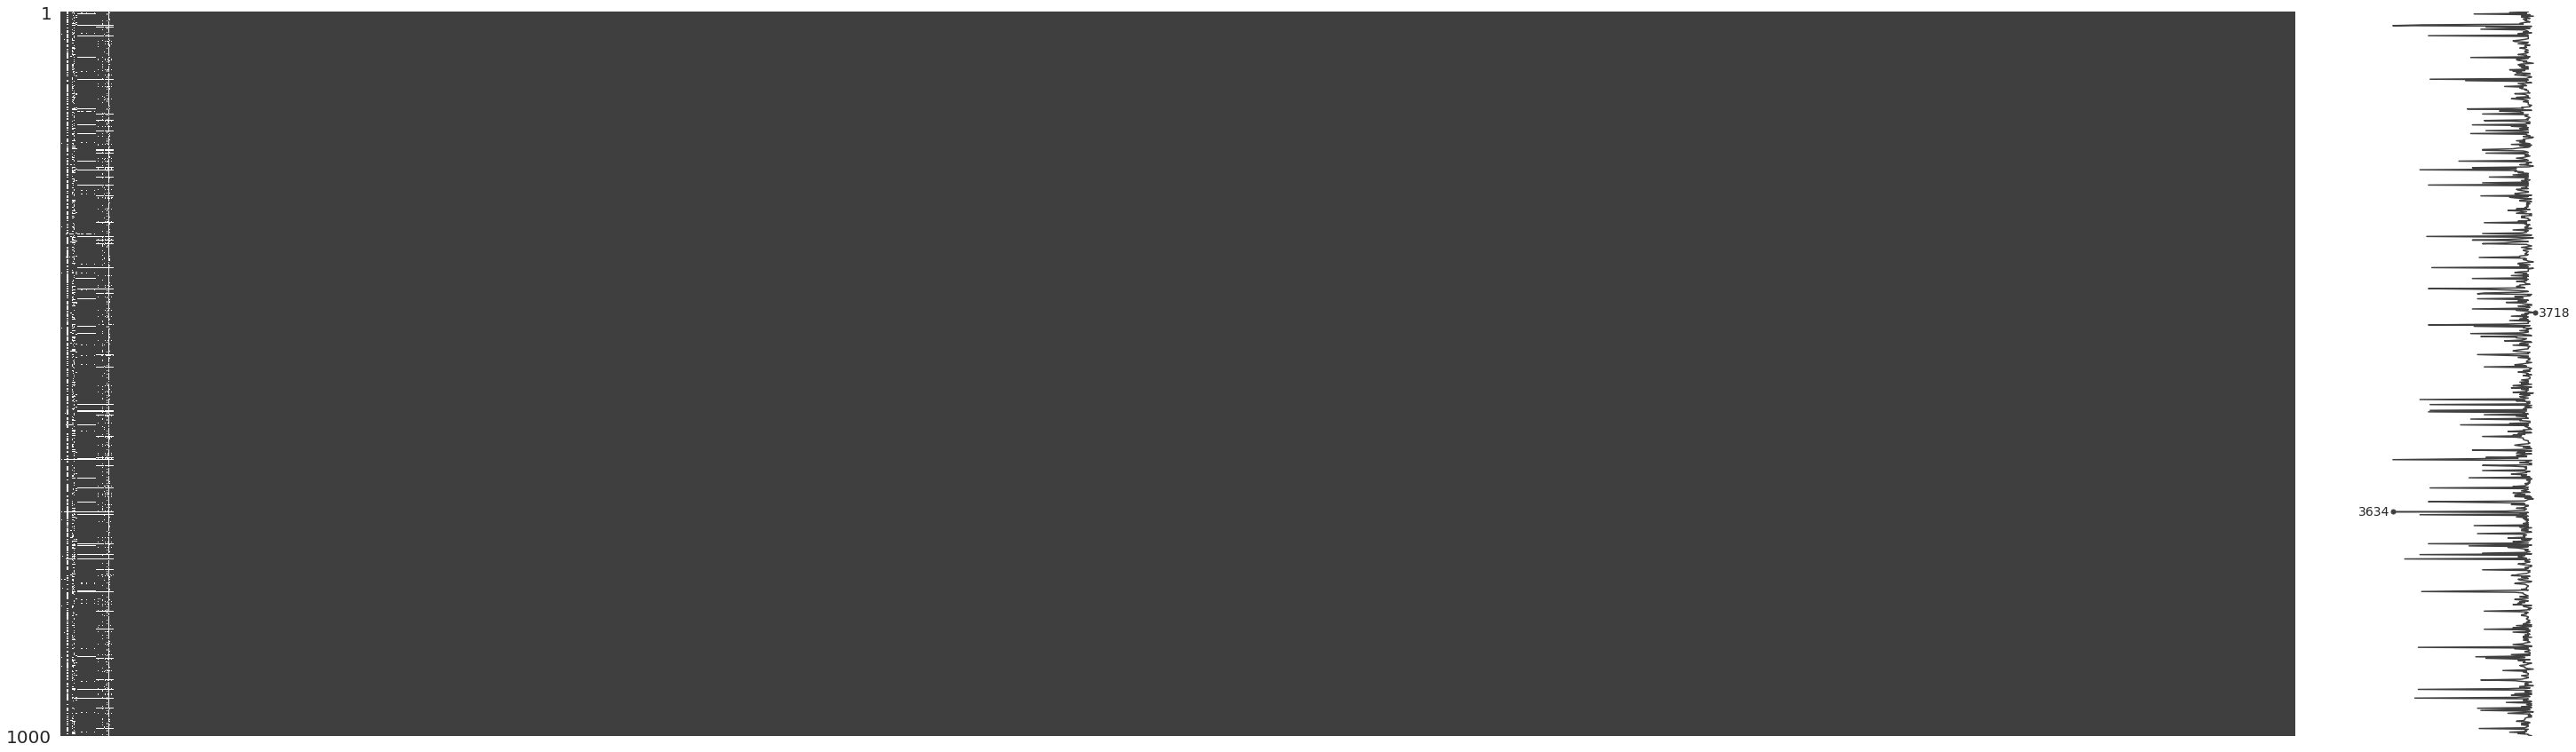

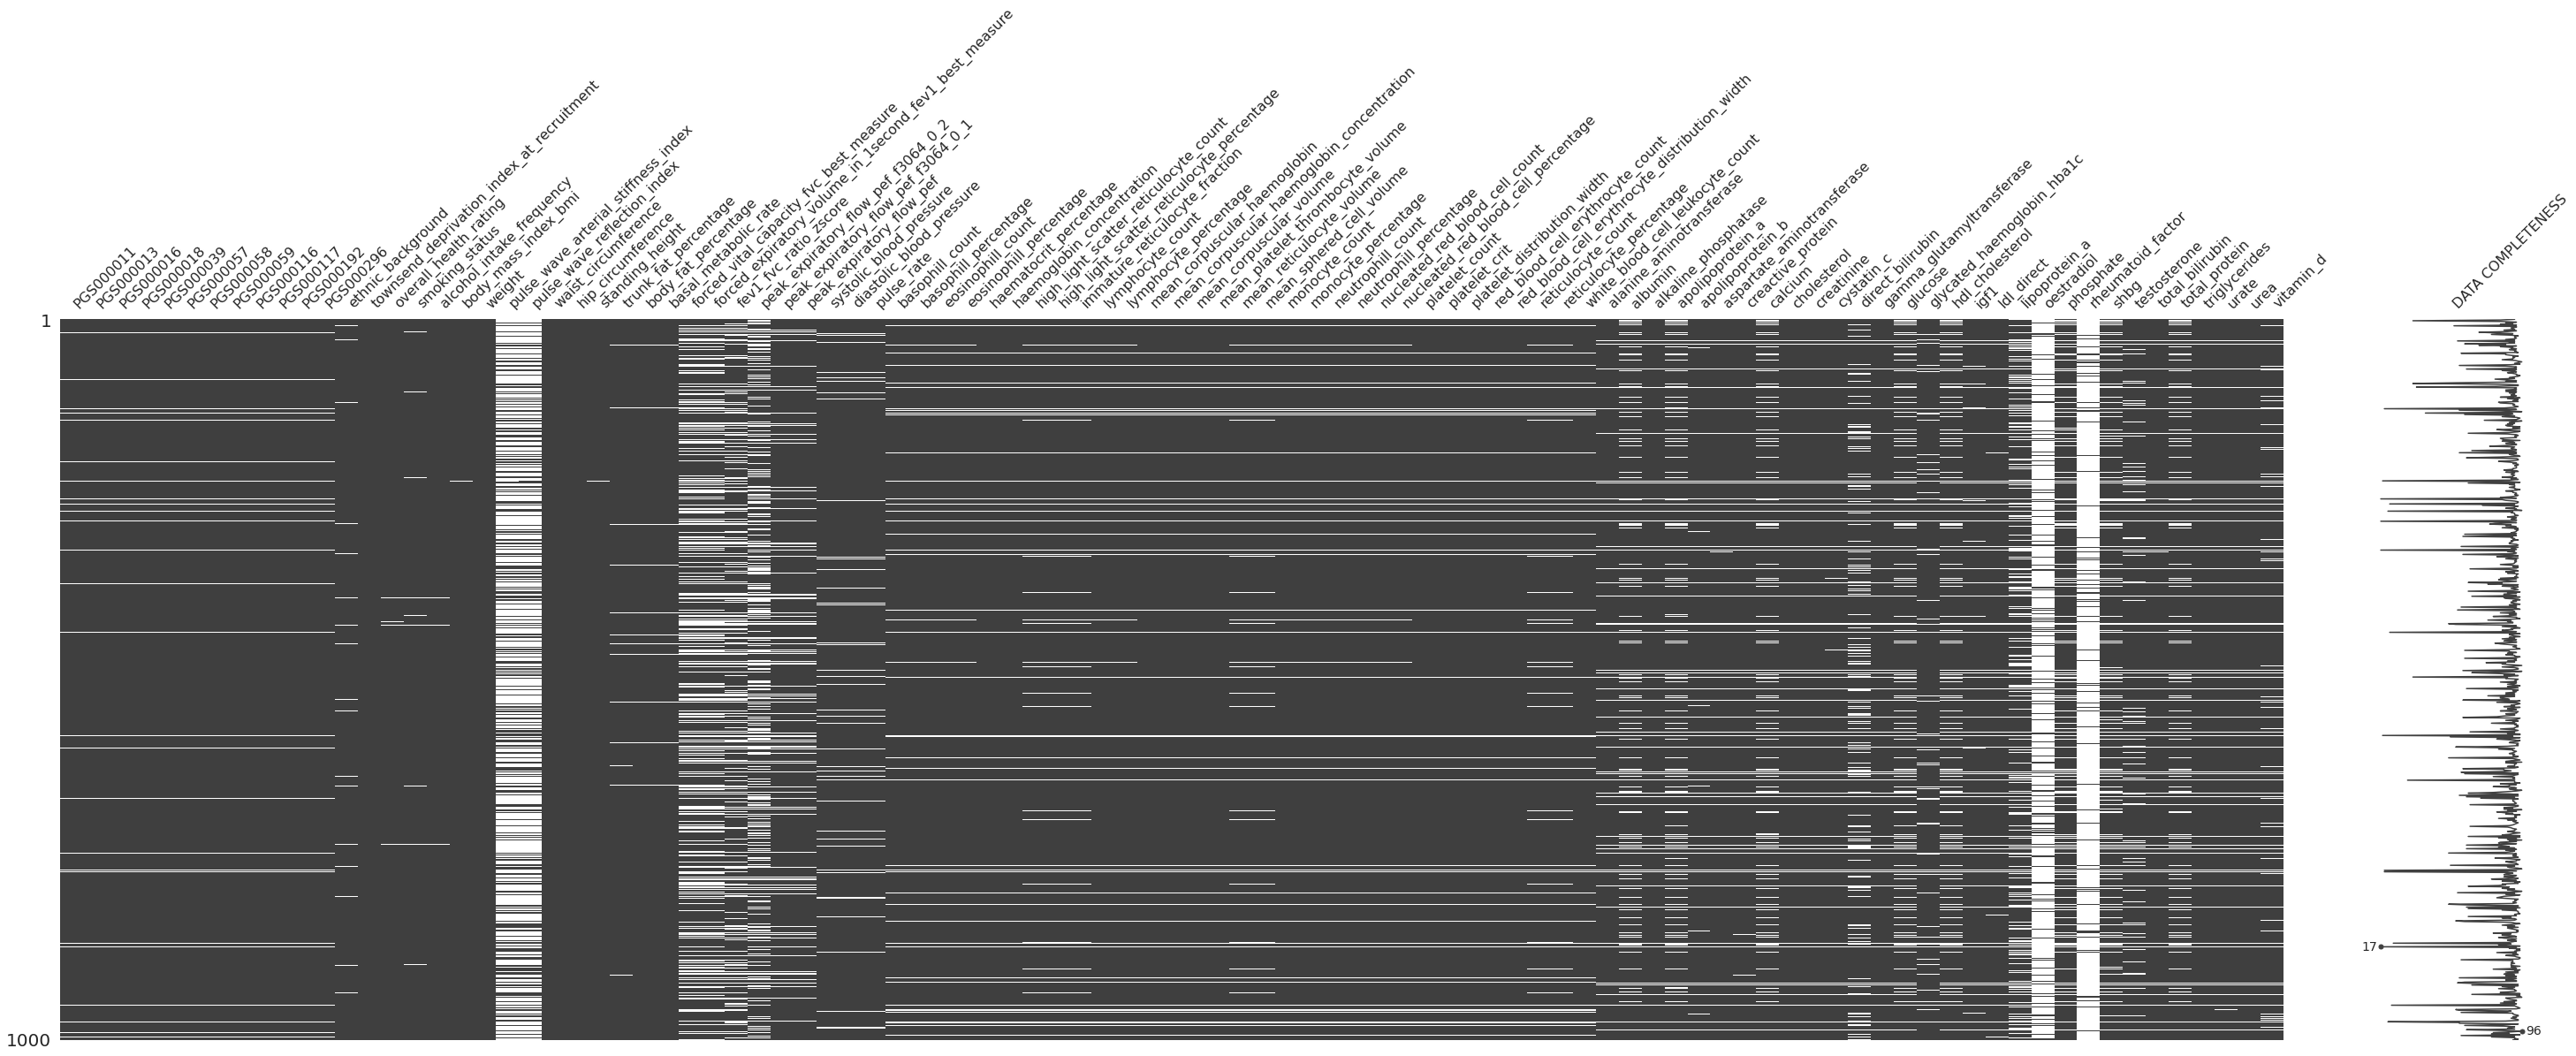

In [30]:
import missingno as msno
%matplotlib inline
fig = matrix(data[covariates].sample(1000), sparkline=True, figsize=(50, 15))

missing = data.columns[data.isnull().any()]
fig = matrix(data[missing].sample(1000), sparkline=True, labels=True, figsize=(50, 15))

## Preprocessing

In [31]:
cat_features = data.select_dtypes(['O', "category"]).columns.to_list()
cat_idx = data.columns.get_indexer(cat_features)

In [32]:
# Show Categories
df = data
for col in cat_features:
    print(df[col].unique())

['Female', 'Male']
Categories (2, object): ['Female', 'Male']
['White', 'Black', NaN, 'Asian', 'Mixed', 'Chinese']
Categories (5, object): ['White', 'Black', 'Asian', 'Mixed', 'Chinese']
[datetime.date(2009, 11, 12) datetime.date(2008, 2, 19)
 datetime.date(2008, 11, 11) ... datetime.date(2006, 3, 13)
 datetime.date(2010, 9, 3) datetime.date(2010, 8, 16)]
[datetime.date(1960, 11, 12) datetime.date(1949, 2, 19)
 datetime.date(1949, 11, 11) ... datetime.date(1938, 3, 22)
 datetime.date(1970, 8, 17) datetime.date(1936, 6, 12)]
['Fair', 'Good', 'Poor', 'Excellent', NaN]
Categories (4, object): ['Poor' < 'Fair' < 'Good' < 'Excellent']
['Current', 'Previous', 'Never', NaN]
Categories (3, object): ['Current' < 'Previous' < 'Never']
['Once or twice a week', 'Three or four times a week', 'One to three times a month', 'Daily or almost daily', 'Special occasions only', 'Never', NaN]
Categories (6, object): ['Daily or almost daily' < 'Three or four times a week' < 'Once or twice a week' < 'One to 

# Encode Categories
from category_encoders import *
enc = OrdinalEncoder(cols=cat_features, handle_missing="return_nan", handle_unknown="return_nan")
enc.fit(data)
data_tf = enc.transform(data)

df = data_tf
for col in cat_features: print(df[col].unique())

## Imputation with miceforest

In [33]:
df = data.sample(10000)
missing = df.columns[df.isnull().any()].to_list()
complete = df.columns[~df.isnull().any()].to_list()

In [34]:
variable_schema = {}
for m in missing: 
    variable_schema[m] = [x for x in missing if x != m]

In [35]:
import miceforest as mf
kernel = mf.KernelDataSet(df, variable_schema=variable_schema, save_all_iterations=True, random_state=1991)

# Run the MICE algorithm for 3 iterations
kernel.mice(3, n_jobs=20, n_estimators=20, max_features="sqrt", bootstrap=True, max_depth=10, verbose=True)

1  | PGS000011 | PGS000013 | PGS000016 | PGS000018 | PGS000039 | PGS000057 | PGS000058 | PGS000059 | PGS000116 | PGS000117 | PGS000192 | PGS000296 | ethnic_background | townsend_deprivation_index_at_recruitment | overall_health_rating | smoking_status | alcohol_intake_frequency | body_mass_index_bmi | weight | pulse_wave_arterial_stiffness_index | pulse_wave_reflection_index | waist_circumference | hip_circumference | standing_height | trunk_fat_percentage | body_fat_percentage | basal_metabolic_rate | forced_vital_capacity_fvc_best_measure | forced_expiratory_volume_in_1second_fev1_best_measure | fev1_fvc_ratio_zscore | peak_expiratory_flow_pef_f3064_0_2 | peak_expiratory_flow_pef_f3064_0_1 | peak_expiratory_flow_pef | systolic_blood_pressure | diastolic_blood_pressure | pulse_rate | basophill_count | basophill_percentage | eosinophill_count | eosinophill_percentage | haematocrit_percentage | haemoglobin_concentration | high_light_scatter_reticulocyte_count | high_light_scatter_reticu

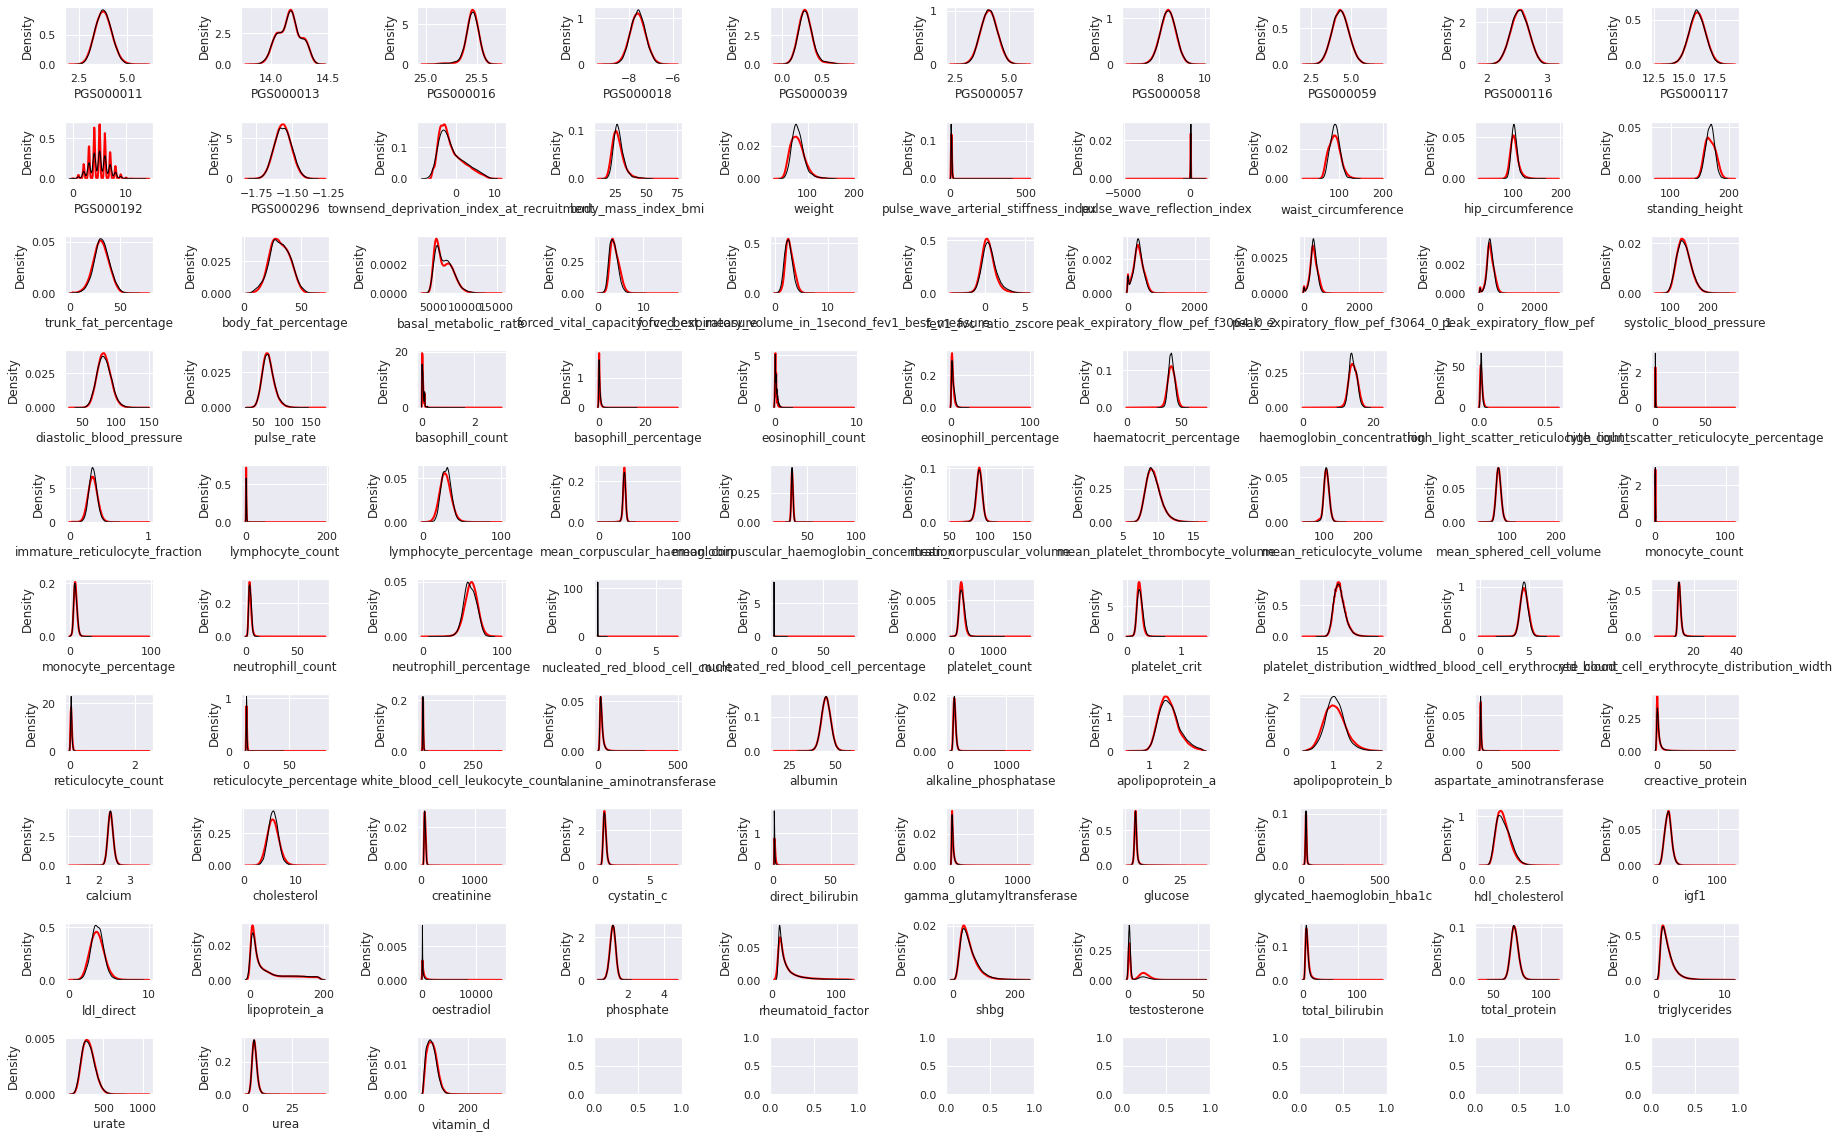

In [36]:
import seaborn as sns

sns.set(rc={'figure.figsize':(30,20)})
kernel.plot_imputed_distributions(wspace=1, hspace=1)

import miceforest as mf
kds = mf.KernelDataSet(df, mean_match_candidates = 10, save_all_iterations=True, random_state=1991)

Run the MICE algorithm for 3 iterations
kds.mice(3, n_jobs=10, n_estimators=10, max_features="sqrt", bootstrap=True, max_depth=10, verbose=True)

import seaborn as sns

sns.set(rc={'figure.figsize':(30,20)})
kds.plot_imputed_distributions(wspace=1,hspace=1)

In [37]:
#kernel_all = kernel.impute_new_data(data, verbose=True)

In [38]:
# get back imputed data
#data_imp = kernel_all.complete_data()
data_imp = kernel.complete_data()

In [39]:
# for validation set
# data_imp_pre = kds.impute_new_data(data, verbose=True)

In [40]:
data_imp

,eid,PGS000011,PGS000013,PGS000016,PGS000018,PGS000039,PGS000057,PGS000058,PGS000059,PGS000116,...,death_cvd_event,death_cvd_event_time,SCORE_event,SCORE_event_time,ASCVD_event,ASCVD_event_time,QRISK3_event,QRISK3_event_time,MACE_event,MACE_event_time
0,1000018,3.170770,14.182161,25.478597,-7.910004,0.196099,3.690275,8.513230,4.060235,2.543097,...,0,10.625599,0,10.625599,0,10.335387,0,10.335387,0,10.335387
1,1000020,3.935565,14.203609,25.508855,-7.338207,0.382054,4.170000,8.665529,3.640000,2.575014,...,0,12.355921,0,12.355921,0,12.065708,0,12.065708,0,12.065708
2,1000037,4.223654,14.248176,25.549722,-7.533061,0.189988,4.288627,8.540908,5.541451,2.441255,...,0,11.627652,0,11.627652,1,7.969884,1,7.969884,0,11.337440
3,1000043,3.529575,14.176502,25.394145,-7.768648,0.289388,4.130000,8.515447,4.261098,2.740589,...,0,11.069131,0,11.069131,1,5.122519,1,5.122519,1,5.122519
4,1000051,3.892568,14.194866,25.445731,-7.851320,0.291973,3.960000,7.834208,3.920980,2.634049,...,0,14.050650,0,14.050650,0,13.760438,0,13.760438,0,13.760438
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
502499,6025150,4.181800,14.053589,25.402026,-7.499164,0.272956,4.470000,8.425411,4.660235,2.419166,...,0,12.996578,0,12.996578,0,12.706366,0,12.706366,0,12.706366
502500,6025165,4.315743,14.131477,25.417482,-7.736421,0.275103,3.900941,8.046961,4.000196,2.721753,...,0,11.819302,0,11.819302,0,11.529090,0,11.529090,0,11.529090
502501,6025173,3.096671,14.186225,25.488755,-8.079815,0.352918,3.507804,7.994697,3.690706,2.687853,...,0,11.778234,0,11.778234,0,11.488022,0,11.488022,0,11.488022
502502,6025182,3.699646,14.134693,25.439013,-7.962928,0.343860,4.020000,8.151277,3.960000,2.692526,...,0,9.993155,0,9.993155,0,9.702943,0,9.702943,0,9.702943


In [41]:
df = data_imp
for col in cat_features:
    print(df[col].unique())

['Female', 'Male']
Categories (2, object): ['Female', 'Male']
['White', 'Black', 'Asian', 'Mixed', 'Chinese']
Categories (5, object): ['White', 'Black', 'Asian', 'Mixed', 'Chinese']
[datetime.date(2009, 11, 12) datetime.date(2008, 2, 19)
 datetime.date(2008, 11, 11) ... datetime.date(2006, 3, 13)
 datetime.date(2010, 9, 3) datetime.date(2010, 8, 16)]
[datetime.date(1960, 11, 12) datetime.date(1949, 2, 19)
 datetime.date(1949, 11, 11) ... datetime.date(1938, 3, 22)
 datetime.date(1970, 8, 17) datetime.date(1936, 6, 12)]
['Fair', 'Good', 'Poor', 'Excellent']
Categories (4, object): ['Poor' < 'Fair' < 'Good' < 'Excellent']
['Current', 'Previous', 'Never']
Categories (3, object): ['Current' < 'Previous' < 'Never']
['Once or twice a week', 'Three or four times a week', 'One to three times a month', 'Daily or almost daily', 'Special occasions only', 'Never']
Categories (6, object): ['Daily or almost daily' < 'Three or four times a week' < 'Once or twice a week' < 'One to three times a month'

## Visualize Post Imputation

In [42]:
2+2

4

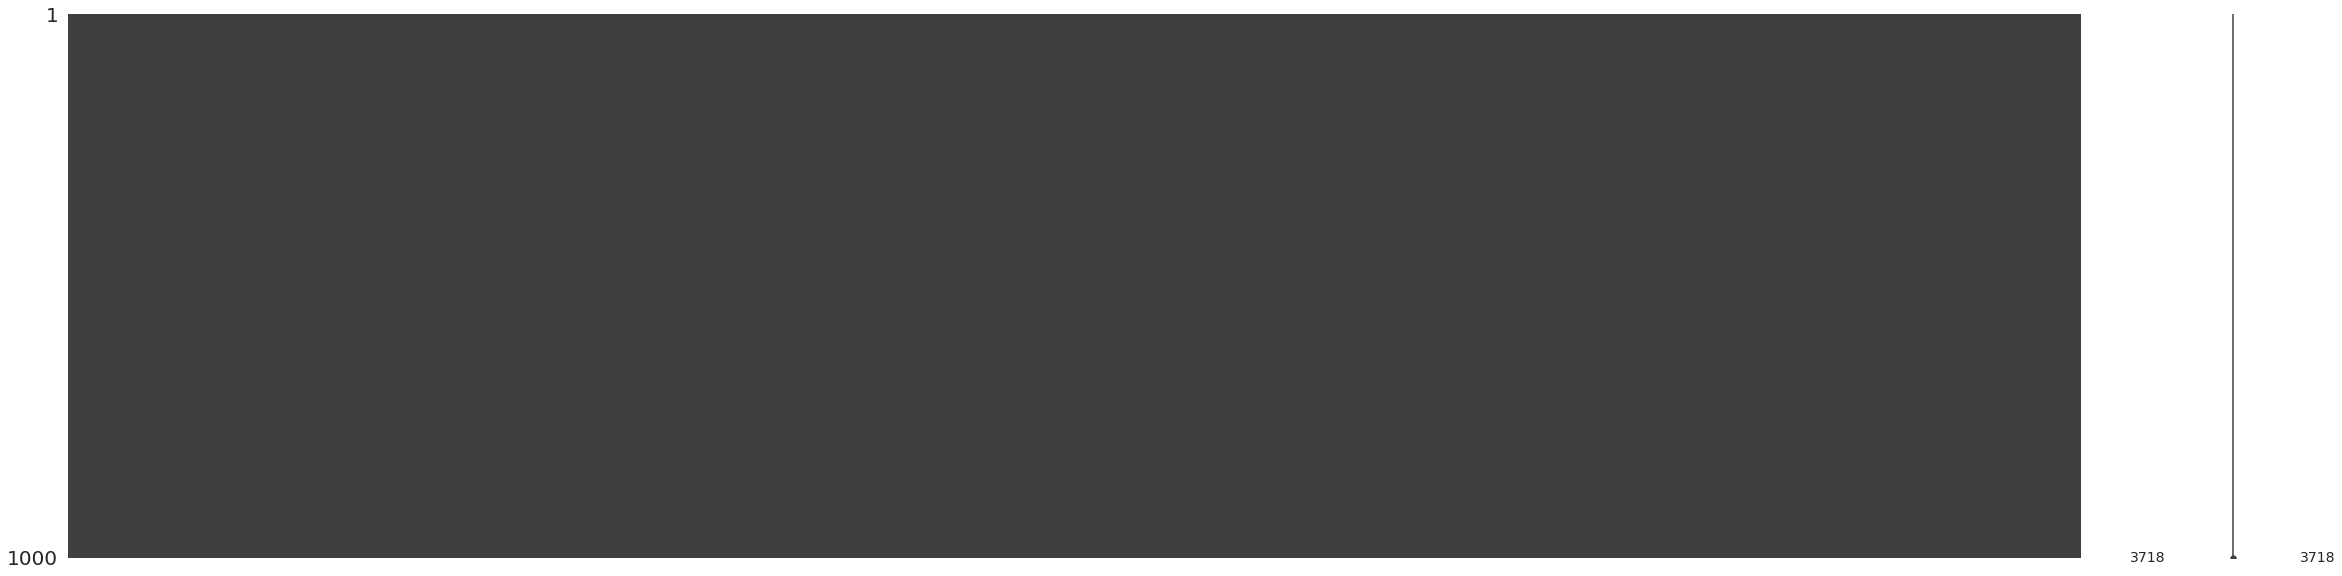

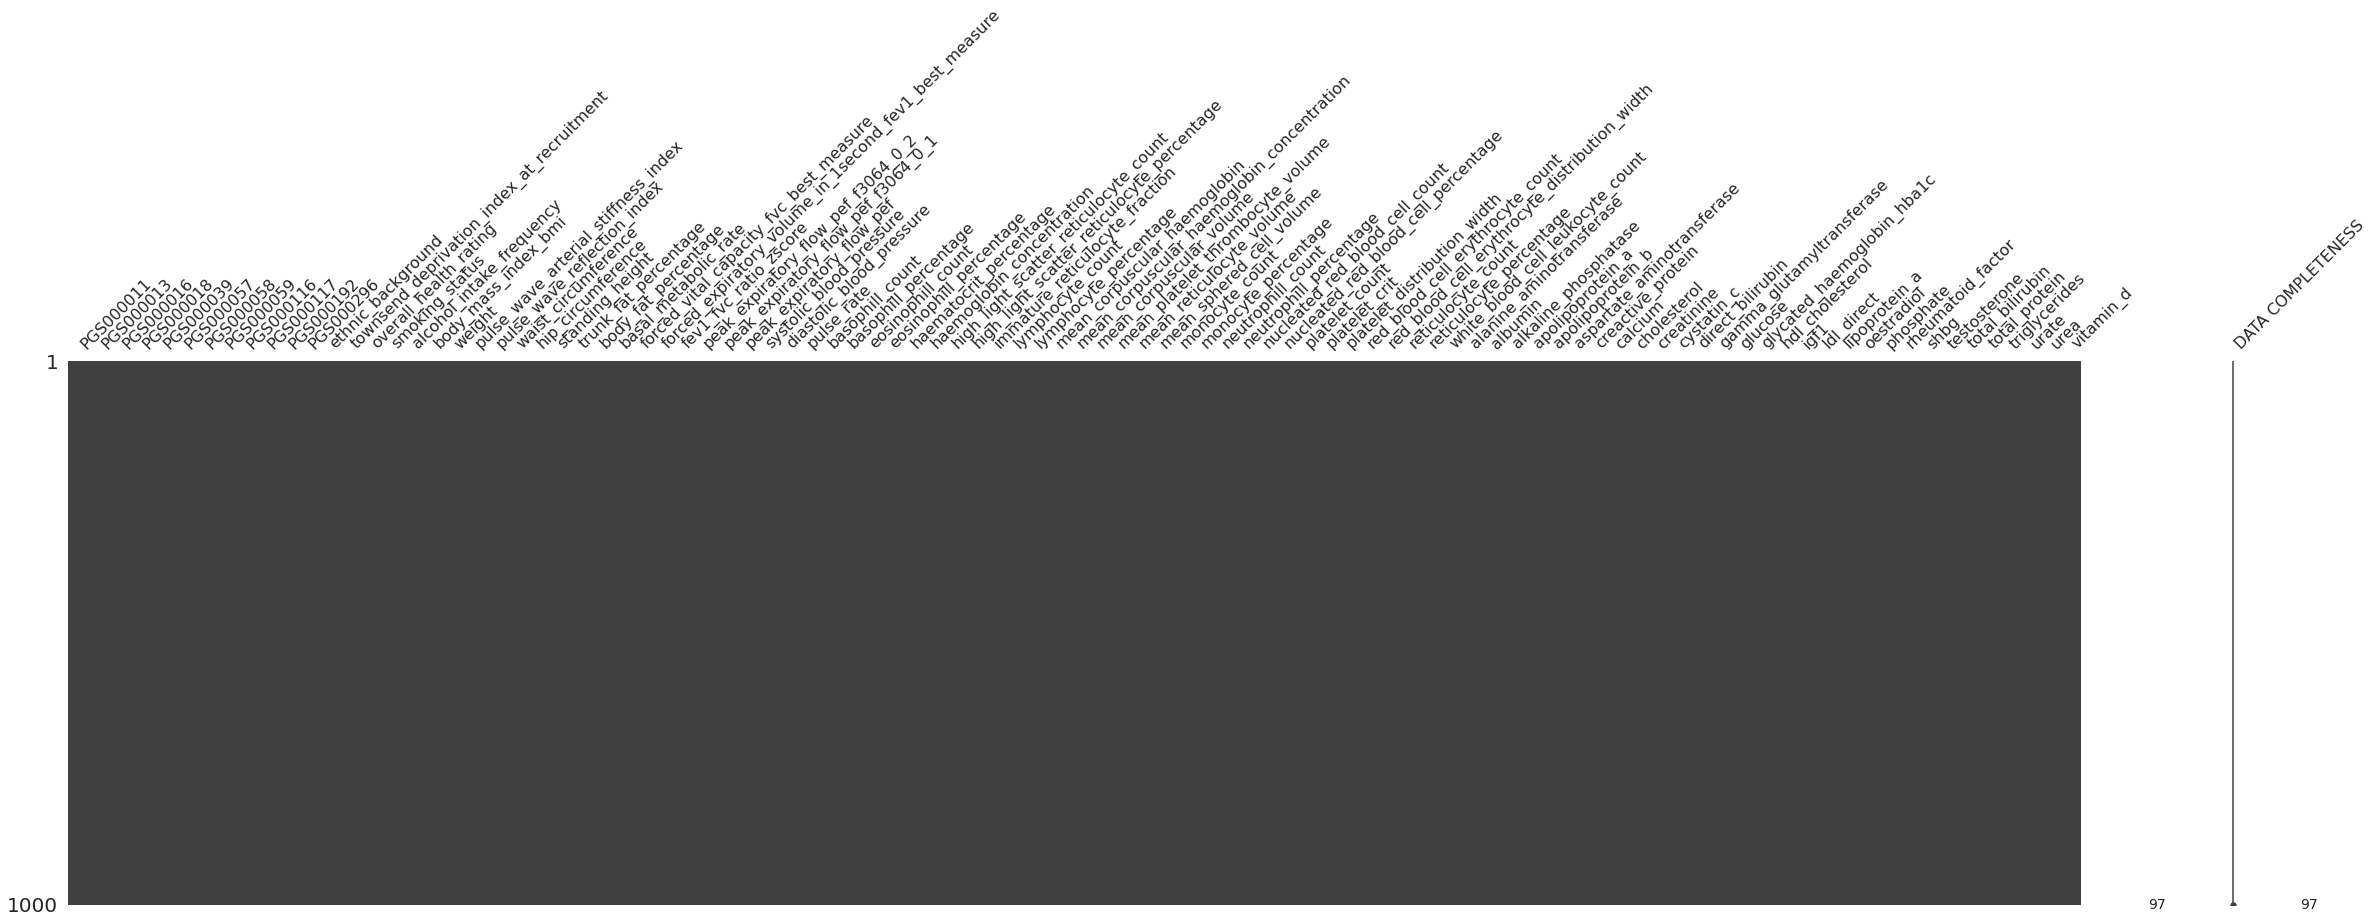

In [43]:
import missingno as msno
%matplotlib inline
fig = matrix(data_imp[covariates].sample(1000), sparkline=True, figsize=(40, 10))

missing = data.columns[data.isnull().any()]
fig = matrix(data_imp[missing].sample(1000), sparkline=True, labels=True, figsize=(40, 10))

## Write to disk

In [44]:
data_imp.to_feather(f"{dataset_path}/baseline_complete_imputed.feather")

## Plus 1 year 

In [45]:
data_imp_yearplus1 = data_imp.copy()
event_time_cols = [s for s in data.columns.to_list() if "_event_time" in s] 
data_imp[event_time_cols].head()

,myocardial_infarction_event_time,stroke_event_time,cancer_breast_event_time,diabetes_event_time,atrial_fibrillation_event_time,copd_event_time,dementia_event_time,death_allcause_event_time,death_cvd_event_time,SCORE_event_time,ASCVD_event_time,QRISK3_event_time,MACE_event_time
0,10.335387,10.335387,10.335387,10.335387,10.335387,10.335387,10.335387,10.625599,10.625599,10.625599,10.335387,10.335387,10.335387
1,12.065708,12.065708,12.065708,12.065708,12.065708,12.065708,12.065708,12.355921,12.355921,12.355921,12.065708,12.065708,12.065708
2,11.337440,11.337440,11.337440,11.337440,11.337440,11.337440,11.337440,11.627652,11.627652,11.627652,7.969884,7.969884,11.337440
3,5.122519,10.778919,10.778919,10.778919,10.778919,0.292950,10.778919,11.069131,11.069131,11.069131,5.122519,5.122519,5.122519
4,13.760438,13.760438,13.760438,4.722793,13.760438,4.840520,13.760438,14.050650,14.050650,14.050650,13.760438,13.760438,13.760438


In [46]:
for col in event_time_cols: data_imp_yearplus1[col] = data_imp_yearplus1[col]+1
data_imp_yearplus1[event_time_cols].head()

,myocardial_infarction_event_time,stroke_event_time,cancer_breast_event_time,diabetes_event_time,atrial_fibrillation_event_time,copd_event_time,dementia_event_time,death_allcause_event_time,death_cvd_event_time,SCORE_event_time,ASCVD_event_time,QRISK3_event_time,MACE_event_time
0,11.335387,11.335387,11.335387,11.335387,11.335387,11.335387,11.335387,11.625599,11.625599,11.625599,11.335387,11.335387,11.335387
1,13.065708,13.065708,13.065708,13.065708,13.065708,13.065708,13.065708,13.355921,13.355921,13.355921,13.065708,13.065708,13.065708
2,12.337440,12.337440,12.337440,12.337440,12.337440,12.337440,12.337440,12.627652,12.627652,12.627652,8.969884,8.969884,12.337440
3,6.122519,11.778919,11.778919,11.778919,11.778919,1.292950,11.778919,12.069131,12.069131,12.069131,6.122519,6.122519,6.122519
4,14.760438,14.760438,14.760438,5.722793,14.760438,5.840520,14.760438,15.050650,15.050650,15.050650,14.760438,14.760438,14.760438


In [47]:
data_imp.to_feather(f"{dataset_path}/baseline_complete_imputed_years+1.feather")